In [24]:
import torch as t
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import matplotlib.gridspec as gridspec
%matplotlib inline

from matplotlib.font_manager import FontProperties

In [25]:
# get data
words = open("names.txt", 'r').read().splitlines()

# lookup tables for s --> i || i --> s
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s,i in stoi.items()}
vocab_size = len(itos)

In [26]:
# build the dataset
block_size = 8

def build_dataset(data):
    """
    creates X tensor which contains input tensors, and Y tensor, which contains the associated output
    :param block_size: number of necessary characters to predict the next tone
    :param itos: lookup table from string to int
    :param stoi: lookup table from int to string
    :param data: list of names, nouns, etc.
    :return: tuple of X and Y
    """
    X, Y = [], []
    for w in data:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]    # crop and append

    X = t.tensor(X)
    Y = t.tensor(Y)

    return X, Y

random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# create splits
Xtr,  Ytr  = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])    # 10%
Xte,  Yte  = build_dataset(words[n2:])      # 10%

In [27]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), "-->", itos[y.item()])

........ --> n
.......n --> a
......na --> i
.....nai --> l
....nail --> a
...naila --> n
..nailan --> i
.nailani --> .
........ --> m
.......m --> i
......mi --> l
.....mil --> a
....mila --> y
...milay --> s
..milays --> i
.milaysi --> a
milaysia --> .
........ --> a
.......a --> v
......av --> a


In [28]:
class Linear:

    def __init__(self, in_features, out_features, bias=True):
        self.weight = t.randn((in_features, out_features)) / in_features**0.5
        self.bias = t.zeros(out_features) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):

        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = t.ones(dim)
        self.beta = t.zeros(dim)

        # buffers (*trained with a running "momentum update")
        self.running_mean = t.zeros(dim)
        self.running_var = t.ones(dim)

    def __call__(self, x):

        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)    # batch mean
            xvar = x.var(dim, keepdim=True)      # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / t.sqrt(xvar + self.eps)    # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with t.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:

    def __call__(self, x):
        self.out = t.tanh(x)
        return self.out

    def parameters(self):
        return []


class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = t.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]


class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        self.out = x.view(B, T//self.n, C*self.n)
        if self.out.shape[1] == 1:
            self.out = self.out.squeeze(1)
        
        return self.out

    def parameters(self):
        return []


class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all layers and put them in a list
        return [p for layer in self.layers for p in layer.parameters()]


In [29]:
# model initialization
n_embd = 24       # dimensionality of the character embedding vectors
n_hidden = 128    # number of neurons in the hidden layer

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2,   n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with t.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()

# total number of parameters
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

76579


In [30]:
# optimization
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = t.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]    # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < (3*max_steps/4) else 0.01    # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f"steps: {i:6d}/{max_steps:6d} | loss: {loss.item():.4f} | learning rate: {lr}")
    lossi.append(loss.log10().item())

steps:      0/200000 | loss: 3.2938 | learning rate: 0.1
steps:  10000/200000 | loss: 2.3858 | learning rate: 0.1
steps:  20000/200000 | loss: 2.4497 | learning rate: 0.1
steps:  30000/200000 | loss: 1.9497 | learning rate: 0.1
steps:  40000/200000 | loss: 1.7455 | learning rate: 0.1
steps:  50000/200000 | loss: 2.1910 | learning rate: 0.1
steps:  60000/200000 | loss: 2.1099 | learning rate: 0.1
steps:  70000/200000 | loss: 1.5313 | learning rate: 0.1
steps:  80000/200000 | loss: 2.0925 | learning rate: 0.1
steps:  90000/200000 | loss: 2.1800 | learning rate: 0.1
steps: 100000/200000 | loss: 1.6907 | learning rate: 0.1
steps: 110000/200000 | loss: 2.2945 | learning rate: 0.1
steps: 120000/200000 | loss: 1.6628 | learning rate: 0.1
steps: 130000/200000 | loss: 2.2740 | learning rate: 0.1
steps: 140000/200000 | loss: 1.8219 | learning rate: 0.1
steps: 150000/200000 | loss: 2.0218 | learning rate: 0.01
steps: 160000/200000 | loss: 1.8087 | learning rate: 0.01
steps: 170000/200000 | loss: 

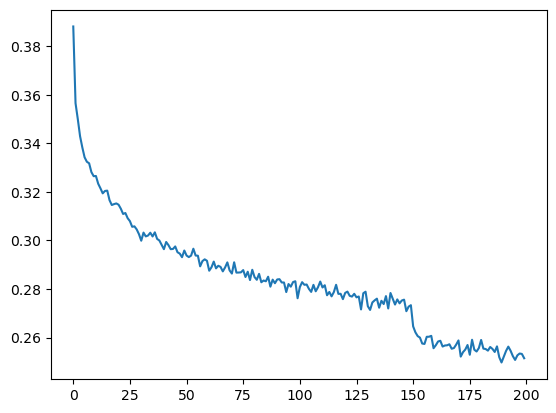

In [31]:
# reshape lossi into a tensor
lossi = t.tensor(lossi).view(-1, 1000).mean(1)
plt.plot(lossi)

In [32]:
# put all layers into eval mode
for layer in model.layers:
    layer.training = False

In [33]:
@t.no_grad()    # decorator that disables gradient tracking
def split_loss(split):
    x,y = {"train": (Xtr, Ytr),
           "val": (Xdev, Ydev),
           "test": (Xte, Yte)}[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

# evaluate the train and validation loss
split_loss("train")
split_loss("val")

train 1.767919659614563
val 1.9932291507720947


In [44]:
# sample from the model
for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        
        # forward pass the neural net
        logits = model(t.tensor([context]))
        probs = F.softmax(logits, dim=1)
        
        # sample from the distribution
        ix = t.multinomial(probs, num_samples=1).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special "." token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

ainaan.
lanny.
canora.
elli.
elina.
eastan.
rayyan.
mikaela.
romilon.
annar.
amartia.
sareyah.
jalaiyah.
rylee.
yanyl.
jim.
broda.
oluwin.
decton.
nuregha.
